In [1]:
%cd /home/a_razumov/projects/k-space-mri
%env CUDA_VISIBLE_DEVICES=1
import os
import sys
from k_space_reconstruction.nets.unet import UnetSMPModule, Unet
from k_space_reconstruction.nets.enet import ENet
from k_space_reconstruction.nets.mwcnn import MWCNN
from k_space_reconstruction.utils.kspace import EquispacedMaskFunc, RandomMaskFunc
from k_space_reconstruction.utils.kspace import pt_spatial2kspace as Ft
from k_space_reconstruction.utils.kspace import pt_kspace2spatial as IFt
import datetime
import torch
import torchvision
import numpy as np
import pylab as plt
plt.style.use('dark_background')
import albumentations
from tqdm.notebook import tqdm
import numpy as np
import h5py
import pylab as plt
import torch
import torch.nn.functional as F

import os
import re
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
import nibabel

import torchio as tio
from torchio import AFFINE, DATA
from pathlib import Path

import torch
import torch.nn as nn
import torch.utils.data
import torchvision.transforms as transforms

from os.path import isdir, join
from typing import Callable, Dict, List, Any

/home/a_razumov/projects/k-space-mri
env: CUDA_VISIBLE_DEVICES=1


In [2]:
class DiceCoeffClass(nn.Module):
    def __init__(self, eps: float = 1e-11):
        super(DiceCoeffClass, self).__init__()
        self.eps = eps
        
    def forward(self,
                logits: torch.Tensor,
                targets: torch.Tensor) -> torch.Tensor:
        
        num = targets.size(0)
        probability = torch.sigmoid(logits)
        dice_ls = []
        for i in range(num):
            yp = probability[i].flatten()
            yt = targets[i].flatten()        
            intersection = 2.0 * (yp * yt).sum()
            union = yp.sum() + yt.sum()
            dice_score = intersection / (union + self.eps)
            dice_ls.append(dice_score)
        #print("intersection", intersection, union, dice_score)
        return dice_ls

class DiceLoss(nn.Module):
    """Calculate dice loss."""
    def __init__(self, eps: float = 1e-9):
        super(DiceLoss, self).__init__()
        self.eps = eps
        
    def forward(self,
                logits: torch.Tensor,
                targets: torch.Tensor) -> torch.Tensor:
        
        num = targets.size(0)
        probability = torch.sigmoid(logits)
        probability = probability.reshape(num, -1)
        targets = targets.reshape(num, -1)
        assert(probability.shape == targets.shape)
        
        intersection = 2.0 * (probability * targets).sum()
        union = probability.sum() + targets.sum()
        dice_score = (intersection + self.eps) / union
        #print("intersection", intersection, union, dice_score)
        return 1.0 - dice_score
        
        
class BCEDiceLoss(nn.Module):
    """Compute objective loss: BCE loss + DICE loss."""
    def __init__(self):
        super(BCEDiceLoss, self).__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()
        
    def forward(self, 
                logits: torch.Tensor,
                targets: torch.Tensor) -> torch.Tensor:
        assert(logits.shape == targets.shape)
        dice_loss = self.dice(logits, targets.float())
        bce_loss = self.bce(logits, targets.float())
        
        return bce_loss + dice_loss
    

class DoubleConv(nn.Module):
    """(Conv3D -> BN -> ReLU) * 2"""
    def __init__(self, in_channels, out_channels, num_groups=8):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            #nn.BatchNorm3d(out_channels),
            nn.GroupNorm(num_groups=num_groups, num_channels=out_channels),
            nn.ReLU(inplace=True),

            nn.Conv3d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            #nn.BatchNorm3d(out_channels),
            nn.GroupNorm(num_groups=num_groups, num_channels=out_channels),
            nn.ReLU(inplace=True)
          )

    def forward(self,x):
        return self.double_conv(x)

    
class Down(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.MaxPool3d(2, 2),
            DoubleConv(in_channels, out_channels)
        )
    def forward(self, x):
        return self.encoder(x)

    
class Up(nn.Module):

    def __init__(self, in_channels, out_channels, trilinear=True):
        super().__init__()
        
        if trilinear:
            self.up = nn.Upsample(scale_factor=2, mode='trilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose3d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)
            
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        diffZ = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        diffX = x2.size()[4] - x1.size()[4]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2, diffZ // 2, diffZ - diffZ // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

    
class Out(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv3d(in_channels, out_channels, kernel_size = 1)

    def forward(self, x):
        return self.conv(x)


class UNet3d(nn.Module):
    def __init__(self, in_channels, n_classes, n_channels):
        super().__init__()
        self.in_channels = in_channels
        self.n_classes = n_classes
        self.n_channels = n_channels

        self.conv = DoubleConv(in_channels, n_channels)
        self.enc1 = Down(n_channels, 2 * n_channels)
        self.enc2 = Down(2 * n_channels, 4 * n_channels)
        self.enc3 = Down(4 * n_channels, 8 * n_channels)
        self.enc4 = Down(8 * n_channels, 8 * n_channels)

        self.dec1 = Up(16 * n_channels, 4 * n_channels)
        self.dec2 = Up(8 * n_channels, 2 * n_channels)
        self.dec3 = Up(4 * n_channels, n_channels)
        self.dec4 = Up(2 * n_channels, n_channels)
        self.out = Out(n_channels, n_classes)

    def forward(self, x):
        x1 = self.conv(x)
        x2 = self.enc1(x1)
        x3 = self.enc2(x2)
        x4 = self.enc3(x3)
        x5 = self.enc4(x4)

        mask = self.dec1(x5, x4)
        mask = self.dec2(mask, x3)
        mask = self.dec3(mask, x2)
        mask = self.dec4(mask, x1)
        mask = self.out(mask)

        return mask
    
path_dataset = "/home/orogov/brats/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"
root_dir = Path(path_dataset)
flair_path = sorted(list(root_dir.glob('*/*_flair.nii')))
t1_path = sorted(list(root_dir.glob('*/*_t1.nii')))
t1ce_path = sorted(list(root_dir.glob('*/*_t1ce.nii')))
t2_path = sorted(list(root_dir.glob('*/*_t2.nii')))

seg_path = sorted(list(root_dir.glob('*/*_seg.nii')))

image_paths = []
label_paths = []

def convert_path_str(arr):
      for i in arr:
        if "355" in str(i):
              continue
        flair_ = str(i).replace("flair", "flair")
        t1_ = str(i).replace("flair", "t1")
        t1ce_ = str(i).replace("flair", "t1ce")
        t2_ = str(i).replace("flair", "t2")
        image_paths.append({"flair": flair_, "t1": t1_, "t1ce": t1ce_, "t2": t2_})

convert_path_str(flair_path)

for i in seg_path:
    label_paths.append(str(i))
    
subjects = []
for (image_path, label_path) in zip(image_paths, label_paths):
    subject = tio.Subject(
        flair=tio.ScalarImage(image_path["flair"]),
        t1=tio.ScalarImage(image_path["t1"]),
        t1ce=tio.ScalarImage(image_path["t1ce"]),
        t2=tio.ScalarImage(image_path["t2"]), 
        brain=tio.LabelMap(label_path),
    )
    subjects.append(subject)
dataset = tio.SubjectsDataset(subjects)
print('Dataset size:', len(dataset), 'subjects')

training_transform = tio.Compose([
    tio.ToCanonical(),
#     tio.RandomMotion(p=0.2),
#     tio.RandomBiasField(p=0.3),
#     tio.RandomNoise(p=1),
#     tio.RandomFlip(axes=(0,)),
#     tio.OneOf({
#         tio.RandomAffine(): 0.8,
#         tio.RandomElasticDeformation(): 0.2,
#     }),
])

validation_transform = tio.Compose([
    tio.ToCanonical(),
])

num_subjects = len(dataset)
num_training_subjects = int(0.7 * num_subjects)

training_subjects = subjects[:num_training_subjects]
validation_subjects = subjects[num_training_subjects:]

training_set = tio.SubjectsDataset(
    training_subjects, transform=training_transform)

validation_set = tio.SubjectsDataset(
    validation_subjects, transform=validation_transform)

print('Training set:', len(training_set), 'subjects')
print('Validation set:', len(validation_set), 'subjects')

import enum

AXIS_CONCAT = 1
SPATIAL_DIMENSIONS = 2, 3, 4

class Action(enum.Enum):
    TRAIN = 'Training'
    VALIDATE = 'Validation'
    
def prepare_sbj(batch):
    input_flair = batch['flair'][DATA].unsqueeze(0)
    input_t1 = batch['t1'][DATA].unsqueeze(0)
    input_t1ce = batch['t1ce'][DATA].unsqueeze(0)
    input_t2 = batch['t2'][DATA].unsqueeze(0)
    inputs = torch.cat(
        (input_flair, input_t1, input_t1ce, input_t2), 
        dim=AXIS_CONCAT)
    inputs = torch.movedim(inputs, (0, 1, 2, 3, 4), (0, 1, 4, 3, 2))
    
    mask_tumors = batch['brain'][DATA].unsqueeze(0)

    mask_WT = mask_tumors.clone()
    mask_WT[mask_WT == 1] = 1
    mask_WT[mask_WT == 2] = 1
    mask_WT[mask_WT == 4] = 1

    mask_TC = mask_tumors.clone()
    mask_TC[mask_TC == 1] = 1
    mask_TC[mask_TC == 2] = 0
    mask_TC[mask_TC == 4] = 1

    mask_ET = mask_tumors.clone()
    mask_ET[mask_ET == 1] = 0
    mask_ET[mask_ET == 2] = 0
    mask_ET[mask_ET == 4] = 1

    masks = torch.cat(
        (mask_WT, mask_TC, mask_ET),
        dim=AXIS_CONCAT)
    targets = torch.movedim(masks, (0, 1, 2, 3, 4), (0, 1, 4, 3, 2))

    return inputs[0], targets[0]

def prepare_batch(batch):
    input_flair = batch['flair'][DATA]
    input_t1 = batch['t1'][DATA]
    input_t1ce = batch['t1ce'][DATA]
    input_t2 = batch['t2'][DATA]
    inputs = torch.cat(
        (input_flair, input_t1, input_t1ce, input_t2), 
        dim=AXIS_CONCAT)
    inputs = torch.movedim(inputs, (0, 1, 2, 3, 4), (0, 1, 4, 3, 2))
    
    mask_tumors = batch['brain'][DATA]

    mask_WT = mask_tumors.clone()
    mask_WT[mask_WT == 1] = 1
    mask_WT[mask_WT == 2] = 1
    mask_WT[mask_WT == 4] = 1

    mask_TC = mask_tumors.clone()
    mask_TC[mask_TC == 1] = 1
    mask_TC[mask_TC == 2] = 0
    mask_TC[mask_TC == 4] = 1

    mask_ET = mask_tumors.clone()
    mask_ET[mask_ET == 1] = 0
    mask_ET[mask_ET == 2] = 0
    mask_ET[mask_ET == 4] = 1

    masks = torch.cat(
        (mask_WT, mask_TC, mask_ET),
        dim=AXIS_CONCAT)
    targets = torch.movedim(masks, (0, 1, 2, 3, 4), (0, 1, 4, 3, 2))

    return inputs, targets

import torch.nn.functional as F
import torch.nn as nn

ALPHA = 0.7
GAMMA = 2
BETA = 0.3

def get_focalTverskyLoss(inputs, targets, smooth=1, alpha=ALPHA, beta=BETA, gamma=GAMMA):     
    #flatten label and prediction tensors
    inputs = inputs.reshape(-1)
    targets = targets.reshape(-1)

    #True Positives, False Positives & False Negatives
    TP = (inputs * targets).sum()    
    FP = ((1-targets) * inputs).sum()
    FN = (targets * (1-inputs)).sum()

    Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)  
    FocalTversky = (1 - Tversky)**gamma

    return FocalTversky

def dice_coef_metric(probabilities: torch.Tensor,
                     truth: torch.Tensor,
                     treshold: float = 0.5,
                     eps: float = 1e-9) -> np.ndarray:
    """
    Calculate Dice score for data batch.
    Params:
        probobilities: model outputs after activation function.
        truth: truth values.
        threshold: threshold for probabilities.
        eps: additive to refine the estimate.
        Returns: dice score aka f1.
    """
    scores = []
    num = probabilities.shape[0]
    predictions = (probabilities >= treshold).float()
    assert(predictions.shape == truth.shape)
    for i in range(num):
        prediction = predictions[i]
        truth_ = truth[i]
        intersection = 2.0 * (truth_ * prediction).sum()
        union = truth_.sum() + prediction.sum()
        if truth_.sum() == 0 and prediction.sum() == 0:
            scores.append(1.0)
        else:
            scores.append((intersection + eps) / union)
    return scores

def forward(model, inputs):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=UserWarning)
        inputs = inputs.float()
        inputs = inputs.to(device)
        logits = model(inputs)
        logits = logits.float()
        return logits

def get_model_and_optimizer(device):
    model = UNet3d(in_channels=4, n_classes=3, n_channels=24).to(device)
    optimizer = torch.optim.AdamW(model.parameters())
    return model, optimizer

def run_epoch(epoch_idx, action, loader, model, optimizer):
    is_training = action == Action.TRAIN
    epoch_losses = []
    model.train(is_training)
    for batch_idx, batch in enumerate(tqdm(loader)):
        inputs, targets = prepare_batch(batch, device)
        optimizer.zero_grad()
        with torch.set_grad_enabled(is_training):
            logits = forward(model, inputs)
#             probabilities = F.softmax(logits, dim=AXIS_CONCAT)
            probabilities = torch.sigmoid(logits)
#             batch_losses = get_dice_loss(probabilities, targets)
            batch_losses = get_focalTverskyLoss(probabilities, targets)
            batch_loss = batch_losses.mean()
            if is_training:
                batch_loss.backward()
                optimizer.step()
            epoch_losses.append(batch_loss.item())
    epoch_losses = np.array(epoch_losses)
    print(f'{action.value} mean loss: {epoch_losses.mean():0.3f}')

def train(num_epochs, training_loader, validation_loader, model, optimizer, weights_stem, start):
    run_epoch(0, Action.VALIDATE, validation_loader, model, optimizer)
    for epoch_idx in range(1, num_epochs + 1):
        print('Starting epoch', epoch_idx)
        run_epoch(epoch_idx, Action.TRAIN, training_loader, model, optimizer)
        run_epoch(epoch_idx, Action.VALIDATE, validation_loader, model, optimizer)
        torch.save(model.state_dict(), f'./{weights_stem}_whole_epoch_{epoch_idx+start}.pth')

Dataset size: 368 subjects
Training set: 257 subjects
Validation set: 111 subjects


In [3]:
def dice_coeff_3d_classes(true, logits, eps=1e-11):
    num_classes = logits.shape[0]
    probas = torch.nn.functional.softmax(logits, dim=0)
    probas[probas > 0.5] = 1
    probas[probas <= 0.5] = 0
    pmask = torch.zeros_like(true).float()
    for i in range(1, num_classes): pmask[0] += probas[i] * i
    dice_ls = []
    # WT
    true_1_hot = ((true==1) | (true==2) | (true==3)).float().flatten()
    pred_1_hot = ((pmask==1) | (pmask==2) | (pmask==3)).float().flatten()
    intersection = torch.sum(pred_1_hot * true_1_hot)
    cardinality = torch.sum(pred_1_hot + true_1_hot)
    dice_ls.append((2. * intersection / (cardinality + eps)).item())
    # ET
    true_1_hot = ((true==1) | (true==3)).float().flatten()
    pred_1_hot = ((pmask==1) | (pmask==3)).float().flatten()
    intersection = torch.sum(pred_1_hot * true_1_hot)
    cardinality = torch.sum(pred_1_hot + true_1_hot)
    dice_ls.append((2. * intersection / (cardinality + eps)).item())
    # TC
    true_1_hot = ((true==1)).float().flatten()
    pred_1_hot = ((pmask==1)).float().flatten()
    intersection = torch.sum(pred_1_hot * true_1_hot)
    cardinality = torch.sum(pred_1_hot + true_1_hot)
    dice_ls.append((2. * intersection / (cardinality + eps)).item())
    return dice_ls


class BraTS3dDataset(torch.utils.data.Dataset):

    def __init__(self, hf_path: str, aug=None, indexes=None):
        super().__init__()
        self.hf = h5py.File(hf_path)
        self.aug = aug
        if indexes is not None:
            self.indexes = [str(i) for i in indexes]
        else:
            self.indexes = [k for k in self.hf.keys()]

    def __len__(self) -> int:
        return len(self.indexes)
    
    def __getitem__(self, item: int):
        key = self.indexes[item]
        img = self.hf[key][:-1,:,:,:]
        mask = self.hf[key][-1:,:,:,:]
        mask[mask==4] = 3
        if self.aug:
            aug = self.aug(image=img, mask=mask)
            img = aug['image']
            mask = aug['mask']
        img = torch.tensor(img).float()
        mask = torch.tensor(mask).long()
        img = img.movedim(3,1)
        mask = mask.movedim(3,1)
        mean = img.mean(dim=(2,3)).unsqueeze(2).unsqueeze(2)
        std = img.std(dim=(2,3)).unsqueeze(2).unsqueeze(2)
        img = (img - mean) / (std + 1e-11)
        return mask, img, mean, std


def test_3d_on_classes_sampling_pattern(sampling, model, val_3d_dataset):
    metric = DiceCoeffClass()
    dice_scores = []
    with torch.no_grad():
        for i in tqdm(range(len(val_3d_dataset))):
            b = validation_set[i]
            inputs, targets = prepare_sbj(b)
            img = IFt(Ft(inputs) * sampling).abs()
            logits = model(img.cuda().float().unsqueeze(0))[0].cpu()
            dice_scores.append(metric(logits, targets))
    return dice_scores

In [4]:
import pytorch_lightning as pl
from collections import OrderedDict

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
model = UNet3d(in_channels=4, n_classes=3, n_channels=24).to(device).train(False).eval()
state_dict = pl.utilities.cloud_io.load(
    'notebooks/dls/logs/lightning_logs/version_3/checkpoints/epoch=156-val_loss=0.25977.ckpt', map_location='cpu')['state_dict']
model.load_state_dict(OrderedDict({k[4:]: v for k, v in state_dict.items()}))
for p in model.parameters(): p.requires_grad = False

In [5]:
metric = DiceCoeffClass()
b = validation_set[42]
inputs, targets = prepare_sbj(b)
with torch.no_grad():
    out = model(inputs.cuda().float().unsqueeze(0))[0].cpu()
print(metric(out, targets))
out = torch.sigmoid(out)
out = (out > 0.5).float()

[tensor(0.9104), tensor(0.3762), tensor(0.5999)]


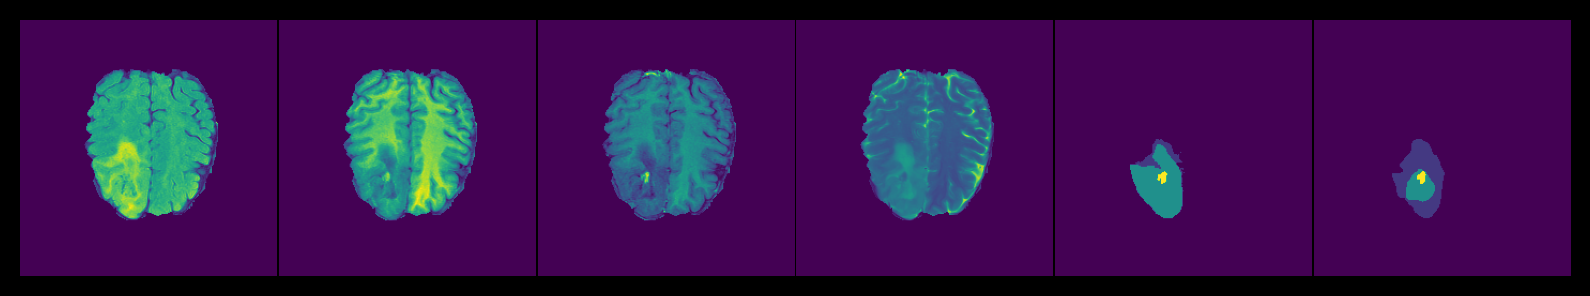

In [6]:
z = 100
fig, ax = plt.subplots(figsize=(10,10), ncols=6, dpi=200,
                       subplot_kw=dict(frameon=False, xticks=[], yticks=[]),
                       gridspec_kw=dict(wspace=0.01, hspace=0.0))
ax[0].imshow(inputs[0,z])
ax[1].imshow(inputs[1,z])
ax[2].imshow(inputs[2,z])
ax[3].imshow(inputs[3,z])
ax[4].imshow(targets[0,z] + targets[1,z] * 2 + targets[2,z] * 3)
im = ax[5].imshow(out[0,z] + out[1,z] * 2 + out[2,z] * 3)
# fig.colorbar(im)
plt.show()

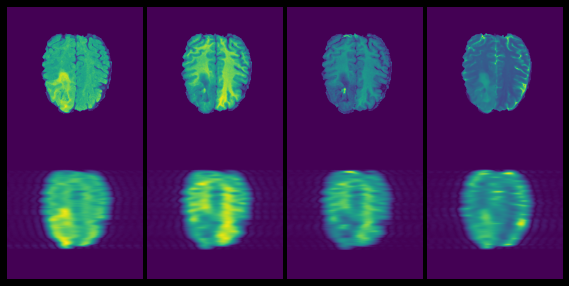

In [7]:
fastmri_mask_x16 = torch.tensor(EquispacedMaskFunc([0.04], [15])((240, 240))[0]).cpu().float().unsqueeze(0).unsqueeze(0).unsqueeze(0)
zm = torch.zeros(240).cpu().float()
zm[240//2 - int(16)//2 : 240//2 + int(16)//2] = 1
zm = zm.unsqueeze(0).unsqueeze(0).unsqueeze(0)
fm = torch.ones(240).cpu().float()

rimg = IFt(Ft(inputs) * zm).abs()
fig,ax = plt.subplots(ncols=4,nrows=2, figsize=(10,5),
                      subplot_kw=dict(frameon=False, xticks=[], yticks=[]),
                      gridspec_kw=dict(wspace=0.01, hspace=0.0))
ax[0,0].imshow(inputs[0,z])
ax[0,1].imshow(inputs[1,z])
ax[0,2].imshow(inputs[2,z])
ax[0,3].imshow(inputs[3,z])
ax[1,0].imshow(rimg[0,z])
ax[1,1].imshow(rimg[1,z])
ax[1,2].imshow(rimg[2,z])
ax[1,3].imshow(rimg[3,z])
plt.show()

In [8]:
fastmri_mask_x16 = torch.tensor(EquispacedMaskFunc([0.04], [15])((240, 240))[0]).cpu().float().unsqueeze(0).unsqueeze(0).unsqueeze(0)
zm = torch.zeros(240).cpu().float()
zm[240//2 - int(16)//2 : 240//2 + int(16)//2] = 1
zm = zm.unsqueeze(0).unsqueeze(0).unsqueeze(0)
fm = torch.ones(240).cpu().float()

dice_scores = dict(
    fastmri=test_3d_on_classes_sampling_pattern(fastmri_mask_x16, model, validation_set), 
    center=test_3d_on_classes_sampling_pattern(zm, model, validation_set),
    full=test_3d_on_classes_sampling_pattern(fm, model, validation_set)
)

In [9]:
class_map = {0: 'WT', 1: 'ET', 2: 'TC'}
for name in dice_scores.keys():
    arr = np.array(dice_scores[name]).T
    print('##############', name, '##############')
    print(pd.DataFrame.from_dict({class_map[i]:arr[i] for i in range(arr.shape[0])}).describe())

############## fastmri ##############
               WT          ET            TC
count  111.000000  111.000000  1.110000e+02
mean     0.590824    0.236126  1.298150e-01
std      0.280375    0.264571  2.051522e-01
min      0.000024    0.000030  0.000000e+00
25%      0.415931    0.000322  9.364532e-07
50%      0.688353    0.154323  4.080383e-04
75%      0.817995    0.430053  2.088453e-01
max      0.916448    0.871875  7.860962e-01
############## center ##############
               WT          ET            TC
count  111.000000  111.000000  1.110000e+02
mean     0.693506    0.359884  2.260520e-01
std      0.268972    0.307801  2.690211e-01
min      0.000035    0.000029  0.000000e+00
25%      0.681532    0.011995  6.291809e-07
50%      0.805940    0.350236  7.386893e-02
75%      0.861350    0.616858  4.482757e-01
max      0.931507    0.899678  8.163559e-01
############## full ##############
               WT          ET          TC
count  111.000000  111.000000  111.000000
mean     0.784